# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. 

In [2]:

import numpy as np
import random
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here we visualise the transverse plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps.

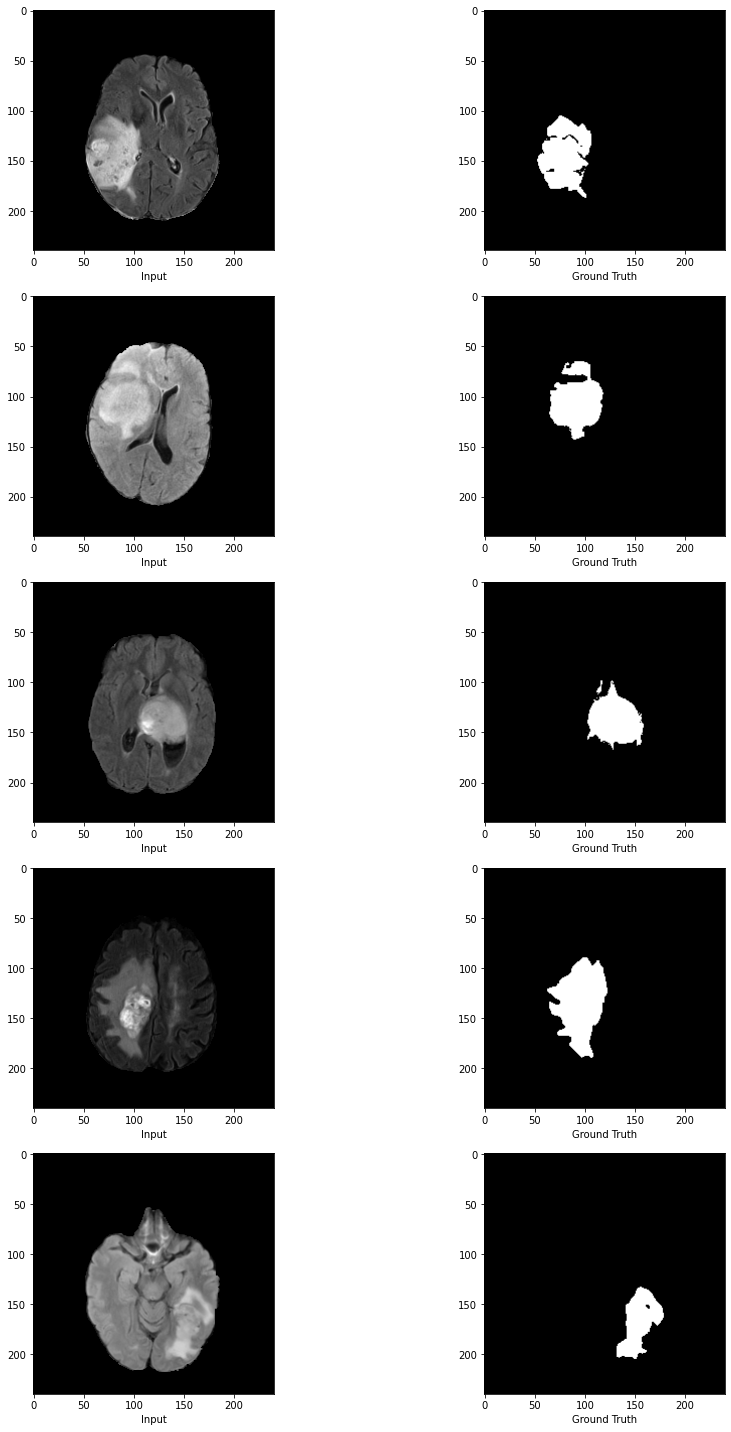

In [4]:
def plot_samples(x,n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

img_path = 'Dataset/'
img_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,CLASS,file_name)
    seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    img_list.append(img)
plot_samples(img_list, n=5)

## Data preprocessing (Optional)

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 

In [6]:
seed = 42
np.random.seed = seed

IMG_CHANNELS = 3


#uncomment if using linux/macos
#!rm -rf Train Val
#!mkdir Train Val Train/Yes Train/No Val/Yes Val/No

#uncomment if using windows
!rmdir Train Val /s /q
!md Train Val Train\Yes Train\No Val\Yes Val\No


img_path = 'Dataset/'
train_list = []
val_list = []
for CLASS in os.listdir(img_path): #所有文件
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files) #随机排序
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*img_num:
                shutil.copy(img, os.path.join('Train/',CLASS,file_name)) #將源文件的內容複製到目標文件或目錄
                train_list.append(os.path.join('Train/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Train/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            else:
                shutil.copy(img, os.path.join('Val/',CLASS,file_name))
                val_list.append(os.path.join('Val/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Val/',CLASS,file_name.split('_')[0]+'_seg.npy'))


## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best segmentation result.


## Get the data generator ready

In [7]:
# 裁剪
# https://zhuanlan.zhihu.com/p/32713815
def random_crop(image, seg, crop_shape, padding=None):
    oshape = np.shape(image)

    if padding:
        oshape = (oshape[0] + 2 * padding, oshape[1] + 2 * padding)

        npad = ((padding, padding), (padding, padding), (0, 0))
        npad_seg = ((padding, padding), (padding, padding))
        
        image_pad = np.lib.pad(image, pad_width=npad, mode='constant', constant_values=0)
        seg_pad = np.lib.pad(seg, pad_width=npad_seg, mode='constant', constant_values=0)
        nh = random.randint(0, oshape[0] - crop_shape[0])
        nw = random.randint(0, oshape[1] - crop_shape[1])
        image_crop = image_pad[nh:nh + crop_shape[0], nw:nw + crop_shape[1]]
        seg_crop = seg_pad[nh:nh + crop_shape[0], nw:nw + crop_shape[1]]
        return image_crop, seg_crop
    else:
        print("WARNING!!! nothing to do!!!")
        return image

In [151]:
# 翻转
def horiz_flip(x, y):
    ran = random.randint(1, 3)
    if ran==1:
        x = np.flip(x, 1) # 左右
        y = np.flip(y, 1)
        return x, y
    elif ran == 2:
        x = np.flip(x, 0) # 上下
        y = np.flip(y, 0)
        return x, y
    else: 
        return x, y


In [152]:
# 噪点
# https://www.cnblogs.com/dylancao/p/9122740.html
def GaussieNoisy(image,sigma):
    row,col,ch= image.shape
    mean = 0
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy.astype(np.uint8)

def spNoisy(image,s_vs_p = 0.5,amount = 0.004):
    row,col,ch = image.shape

    out = np.copy(image)
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))  for i in image.shape]
    out[coords] = 1
    #num_pepper = np.ceil(amount * image.size * (2. - s_vs_p))
    num_pepper = np.ceil(amount * image.size * (1 - 0.5))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

def add_noise(x):
    ran = random.randint(1, 3)
    if ran==1:
        x = GaussieNoisy(x, 0.1) # 高斯
        return x
    elif ran == 2:
        x = spNoisy(x, s_vs_p = 0.5,amount = 0.004) # 上下
        return x
    else: 
        return x 

In [153]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=16, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(shape = (self.batch_size, *self.dim, self.n_channels))
        y = np.empty(shape = (self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            #X[i], y[i] = random_crop(np.load(ID),np.load(val_list[i]), (224, 224), 16)
            X[i], y[i] = horiz_flip(X[i],y[i])
            X[i] = add_noise(X[i])

        return X, y


train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
img_size = (240, 240)

## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

In [154]:
from keras import backend as K
#IoU
# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#   union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#   return iou


# Dice Coefficient (F1 Score)

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

In [155]:
# https://zhuanlan.zhihu.com/p/139631046

In [156]:
# UNet输入模块
def InputBlock(input, filters, kernel_size=3, strides=1, padding='same'):
    down_depth_0_layer_0 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                    activation='relu')(input)  # 卷积块1
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                  activation='relu')(down_depth_0_layer_0)  # 卷积块2

In [157]:
# 收缩路径模块
def ContractingPathBlock(input, filters, kernel_size=3, strides=1, padding='same'):
    down_depth_0_layer_pool = tf.keras.layers.MaxPool2D((2, 2))(input)  # 最大池化
    down_depth_1_layer_0 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                    activation='relu')(down_depth_0_layer_pool)  # 卷积块1
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                    activation='relu')(down_depth_1_layer_0)  # 卷积块2

In [158]:
# 扩张（恢复）路径模块
def ExpansivePathBlock(input, con_feature, filters, tran_filters, kernel_size=3, tran_kernel_size=2, strides=1,
                       tran_strides=2, padding='same', tran_padding='same'):
    upsampling = tf.keras.layers.Conv2DTranspose(filters=tran_filters, kernel_size=tran_kernel_size,
                                                 strides=tran_strides, padding=tran_padding)(input)  # 上采样（转置卷积方式）
    con_feature = tf.image.resize(con_feature, ((upsampling.shape)[1], (upsampling.shape)[2]),
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # 裁剪需要拼接的特征图
    concat_feature = tf.concat([con_feature, upsampling], axis=3)  # 拼接扩张层和收缩层的特征图（skip connection）
    conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                    activation='relu')(concat_feature)  # 卷积1
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                  activation='relu')(conv_1)  # 卷积2

In [159]:
# UNet网络架构
def UNet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    
    
    # input block
    down_depth_0_layer_0 = InputBlock(inputs, 60)

    # contracting path
    con_1 = ContractingPathBlock(down_depth_0_layer_0, 120)
    con_2 = ContractingPathBlock(con_1, 240)
    con_3 = ContractingPathBlock(con_2, 480)
    con_4 = ContractingPathBlock(con_3, 960)

    # expansive path
    exp_4 = ExpansivePathBlock(con_4, con_3, 480, 480)
    exp_3 = ExpansivePathBlock(exp_4, con_2, 240, 240)
    exp_2 = ExpansivePathBlock(exp_3, con_1, 120, 120)
    exp_1 = ExpansivePathBlock(exp_2, down_depth_0_layer_0, 60, 60)

    outputs = tf.keras.layers.Conv2D(2, 1)(exp_1)  # 最终输出

    return tf.keras.Model(inputs=[inputs], outputs=[outputs])

## Train your model here
Once you defined the model and data generator, you can start training your model.

In [160]:
tf.compat.v1.disable_eager_execution()

model = UNet(input_shape=(240, 240, 3))

model.summary()
model.compile(optimizer=Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=['categorical_accuracy'])
earlystopping = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=20
)

results = model.fit(train_generator, validation_data=validation_generator, epochs=2, callbacks=[earlystopping])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 240, 240, 60) 1680        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 240, 240, 60) 32460       conv2d_209[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 120, 120, 60) 0           conv2d_210[0][0]                 
___________________________________________________________________________________________

C:\Users\legion\AppData\Local\Temp\ipykernel_21968\4176150513.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
C:\Users\legion\AppData\Local\Temp\ipykernel_21968\4176150513.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


Epoch 1/2


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: required broadcastable shapes
	 [[{{node metrics_22/categorical_accuracy/Equal}}]]
	 [[metrics_22/categorical_accuracy/Identity/_325]]
  (1) Invalid argument: required broadcastable shapes
	 [[{{node metrics_22/categorical_accuracy/Equal}}]]
0 successful operations.
0 derived errors ignored.